In [508]:
# !py -m pip install pyvista --upgrade
# !py -m pip install ipympl --upgrade
# !py -m pip install trame --upgrade
# !py -m pip install scipy --upgrade
# !py -m pip install imageio --upgrade

In [1]:
import pyvista as pv
import numpy as np

import matplotlib.pyplot as plt
import imageio

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy import optimize
from scipy.special import comb

from math import sqrt, cos, sin, pi, atan2, degrees

from shapely import affinity, distance
from shapely.geometry import Polygon, Point, LinearRing, LineString, MultiPoint
from shapely.plotting import plot_polygon, plot_points, plot_line
from shapely.ops import transform, nearest_points
from shapely.affinity import rotate

from tqdm.notebook import tqdm

# Functions

In [2]:
def matan(point):
    angle = atan2(point.y, point.x)
    if angle <= 0: angle += 2*pi
    return angle

def norma(point):
    return Point(0,0).distance(point)

def Change(val1, val2):
    val1 = val1 + val2
    val2 = val1 - val2
    val1 = val1 - val2
    return val1, val2

In [3]:
def GetContourFromOBJ(filename):
    return LinearRing(MultiPoint(np.delete(pv.read(filename).project_points_to_plane().points, 2, 1)).convex_hull.boundary.coords)

def Contour2Points(contour, n):
    contour_pts = []
    for i in range(n):
        intersection = contour.intersection(LineString([(0,0), (20*cos((i/n)*2*pi), 20*sin((i/n)*2*pi))]))
        if intersection.geom_type == 'Point':
            contour_pts.append(intersection)
        else:
            contour_pts.append(intersection.geoms[-1])
    return contour_pts

def GetAngleOfRotation(contour_pts, pts, i1, i2):
    angle1, angle2 = matan(Point(pts.geoms[i1].x, pts.geoms[i1].y)), matan(Point(pts.geoms[i2].x, pts.geoms[i2].y))
    i_max, nrm_max = 0, norma(contour_pts[0])
    for i in range(1, len(contour_pts)):
        angle_cur = matan(contour_pts[i])
        if angle1 <= angle_cur and angle_cur <= angle2:
            nrm = norma(contour_pts[i])
            if nrm > nrm_max:
                nrm_max = nrm
                i_max = i
    return matan(contour_pts[i_max])

def RotateListOfPoints(contour_pts, angle):
    rotated_contour_pts = []
    for i in range(len(contour_pts)):
        rotated_contour_pts.append(rotate(contour_pts[i], angle, origin=Point(0.0,0.0), use_radians=True))
    return rotated_contour_pts

def TransformListOfPoints(contour_pts, x_trans, y_trans):
    transformed_contour_pts = []
    for i in range(len(contour_pts)):
        transformed_contour_pts.append(transform(lambda x, y, z=None: (x+(x_trans), y+(y_trans)), contour_pts[i]))
    return transformed_contour_pts

In [4]:
def GetEdgeIndices(rough_pts, pt_min, pt_max):
    angle_min, angle_max = matan(pt_min), matan(pt_max)
    if angle_min >= 2*pi: angle_min -= 2*pi

    for i in range(0, len(rough_pts)):
        if matan(rough_pts[i]) > angle_min:
            i_min = i
            break
    for i in range(1, len(rough_pts)):
        if matan(rough_pts[i]) > angle_max:
            i_max = i-1
            break
    return i_min, i_max

In [5]:
def GetPointOnLineWithDistance(line, distance):
    if distance < 0.0 or distance > line.length:
        return None
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return Point(coords[i][0], coords[i][1])
        if pd > distance:
           return line.interpolate(distance)

def get_bezier_parameters(X, Y, degree=3):
    """ Least square qbezier fit using penrose pseudoinverse.
    Parameters:
    X: array of x data.
    Y: array of y data. Y[0] is the y point for X[0].
    degree: degree of the Bézier curve. 2 for quadratic, 3 for cubic.
    """
    if degree < 1:
        raise ValueError('degree must be 1 or greater.')

    if len(X) != len(Y):
        raise ValueError('X and Y must be of the same length.')

    if len(X) < degree + 1:
        raise ValueError(f'There must be at least {degree + 1} points to '
                         f'determine the parameters of a degree {degree} curve. '
                         f'Got only {len(X)} points.')

    def bpoly(n, t, k):
        return t ** k * (1 - t) ** (n - k) * comb(n, k)
        #return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

    def bmatrix(T):
        return np.matrix([[bpoly(degree, t, k) for k in range(degree + 1)] for t in T])

    def least_square_fit(points, M):
        M_ = np.linalg.pinv(M)
        return M_ * points

    T = np.linspace(0, 1, len(X))
    M = bmatrix(T)
    points = np.array(list(zip(X, Y)))
    
    final = least_square_fit(points, M).tolist()
    final[0] = [X[0], Y[0]]
    final[len(final)-1] = [X[len(X)-1], Y[len(Y)-1]]
    return final

def bernstein_poly(i, n, t):
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

def bezier_curve(points, nTimes):
    pts = []
    for i in range(len(points)):
        pts.append([points[i].x, points[i].y])

    nPoints = len(pts)
    xPoints = np.array([p[0] for p in pts])
    yPoints = np.array([p[1] for p in pts])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    trace_pts = []
    for i in range(nTimes):
        trace_pts.append(Point(xvals[i], yvals[i]))

    return trace_pts

In [27]:
def GetNormals(pts):
    al = []
    for i in range(len(pts)):
        al.append([pts[i].x, pts[i].y])

    a = np.array(al)
    dx_dt = np.gradient(a[:, 0])
    dy_dt = np.gradient(a[:, 1])
    velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])

    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

    tangent = np.array([1/ds_dt]).transpose() * velocity

    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    normal = np.array([1/length_dT_dt]).transpose() * dT_dt
    normal_pts = []
    for item in normal:
        normal_pts.append(Point(item[0], item[1]))
    return normal_pts
        
def GetCornerIndices(pts, threshold):
    al = []
    for i in range(len(pts)):
        al.append([pts[i].x, pts[i].y])

    a = np.array(al)
    dx_dt = np.gradient(a[:, 0])
    dy_dt = np.gradient(a[:, 1])
    velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])

    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

    tangent = np.array([1/ds_dt]).transpose() * velocity

    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    normal = np.array([1/length_dT_dt]).transpose() * dT_dt

    d2s_dt2 = np.gradient(ds_dt)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)

    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
    t_component = np.array([d2s_dt2] * 2).transpose()
    n_component = np.array([curvature * ds_dt * ds_dt] * 2).transpose()

    acceleration = t_component * tangent + n_component * normal

    # plt.plot(curvature)
    return [idx for idx, val in enumerate(curvature) if val>=threshold]

def GetBrutingTrace(rough_pts, target_pts, step, steps, threshold):
    alpha = step / steps
    bruting_rough_trace_pts = []
    if step%2 != 0:
        for i in range(len(rough_pts)):
            x1, y1 = rough_pts[i].x, rough_pts[i].y
            x2, y2 = target_pts[i].x, target_pts[i].y
            bruting_rough_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
    else:
        for i in reversed(range(len(rough_pts))):
            x1, y1 = rough_pts[i].x, rough_pts[i].y
            x2, y2 = target_pts[i].x, target_pts[i].y
            bruting_rough_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
    
    bruting_trace_pts = bruting_rough_trace_pts
    
    # mean = GetAverageCurvature(bruting_rough_trace_pts)
    indices = GetCornerIndices(bruting_rough_trace_pts, threshold)

    while len(indices) != 0:
        # print(len(indices))
        bruting_trace_pts = []
        for i in range(len(bruting_rough_trace_pts)):
            if i not in indices:
                bruting_trace_pts.append(bruting_rough_trace_pts[i])
            else:
                pt1 = bruting_rough_trace_pts[i-1]
                pt2 = bruting_rough_trace_pts[i+1]
                pt = bruting_rough_trace_pts[i]
                nrm = norma(pt)
                coeff = (norma(pt1)+norma(pt2))/2
                bruting_trace_pts.append(Point(coeff*pt.x/nrm, coeff*pt.y/nrm))

        bruting_rough_trace_pts = bruting_trace_pts
        # mean = GetAverageCurvature(bruting_rough_trace_pts)
        indices = GetCornerIndices(bruting_rough_trace_pts, threshold)

    # print("Smoothing done")
    
    delta_len = LineString(bruting_trace_pts).length/(len(rough_pts)-1)
    # line = LineString(bruting_trace_pts).segmentize(max_segment_length=delta_len)
    line = LineString(bruting_trace_pts)

    trace_pts = []
    for i in range(len(rough_pts)-1):
        trace_pts.append(GetPointOnLineWithDistance(line, i*delta_len))
    trace_pts.append(bruting_trace_pts[-1])

    return trace_pts

def GetSmoothedContour(pts, threshold):
    n = len(pts)
    indices = GetCornerIndices(pts, threshold)
    iterations = 0
    while len(indices) > 0 and iterations < 1000 and len(pts)==n:
        # print(len(indices))
        bruting_trace_pts = []
        for i in range(len(pts)-1):
            if i not in indices:
                bruting_trace_pts.append(pts[i])
            else:
                pt1 = pts[i-1]
                pt2 = pts[i+1]
                pt = pts[i]
                nrm = norma(pt)
                coeff = (norma(pt1)+norma(pt2))/2
                bruting_trace_pts.append(Point(coeff*pt.x/nrm, coeff*pt.y/nrm))

        pts = bruting_trace_pts
        # mean = GetAverageCurvature(pts)
        indices = GetCornerIndices(pts, threshold)
        # print(len(indices))
        iterations += 1

    if iterations == 1:
        threshold *= 2

    while len(indices) > 0 and iterations < 1000 and len(pts)==n:
        # print(len(indices))
        bruting_trace_pts = []
        for i in range(len(pts)-1):
            if i not in indices:
                bruting_trace_pts.append(pts[i])
            else:
                pt1 = pts[i-1]
                pt2 = pts[i+1]
                pt = pts[i]
                nrm = norma(pt)
                coeff = (norma(pt1)+norma(pt2))/2
                bruting_trace_pts.append(Point(coeff*pt.x/nrm, coeff*pt.y/nrm))

        pts = bruting_trace_pts
        # mean = GetAverageCurvature(pts)
        indices = GetCornerIndices(pts, threshold)
        # print(len(indices))
        iterations += 1
    
    # line = LineString(pts)
    # delta_len = line.length/(n-1)

    # pts = []
    # for i in range(n):
    #     pts.append(GetPointOnLineWithDistance(line, i*delta_len))

    return pts

def GetSwingParallelOffset(bruting_trace_pts, j, R):
    normal_vectors = []
    for i in range(len(bruting_trace_pts)-1):
        pt1, pt2 = bruting_trace_pts[i], bruting_trace_pts[i+1]
        x1, y1 = pt1.x, pt1.y
        x2, y2 = pt2.x, pt2.y
        nrm = sqrt((x2-x1)**2+(y2-y1)**2)
        if j%2 != 0:
            normal_vectors.append(Point(R*(y2-y1)/nrm, -R*(x2-x1)/nrm))
        else:
            normal_vectors.append(Point(-R*(y2-y1)/nrm, R*(x2-x1)/nrm))
    
    normal_vertices = []
    normal_vertices.append(normal_vectors[0])
    for i in range(len(normal_vectors)-1):
        x = (normal_vectors[i].x+normal_vectors[i+1].x)/2
        y = (normal_vectors[i].y+normal_vectors[i+1].y)/2
        normal_vertices.append(Point(x, y))
    normal_vertices.append(normal_vectors[-1])

    disk_trace_pts = []
    for i in range(len(bruting_trace_pts)):
        x = bruting_trace_pts[i].x+normal_vertices[i].x
        y = bruting_trace_pts[i].y+normal_vertices[i].y
        disk_trace_pts.append(Point(x, y))

    # return list(MultiPoint(LineString(bruting_trace_pts).parallel_offset(R, 'right', join_style=1).coords).geoms)
    return disk_trace_pts

def GetParallelOffset(pts, dist, R):

    normal_vectors = []
    for i in range(len(pts)-1):
        pt1, pt2 = pts[i], pts[i+1]
        x1, y1 = pt1.x, pt1.y
        x2, y2 = pt2.x, pt2.y
        nrm = sqrt((x2-x1)**2+(y2-y1)**2)
        normal_vectors.append(Point((y2-y1)/nrm, -(x2-x1)/nrm))

    normal_vertices = []
    normal_vertices.append(normal_vectors[0])
    for i in range(len(normal_vectors)-1):
        x = (normal_vectors[i].x+normal_vectors[i+1].x)/2
        y = (normal_vectors[i].y+normal_vectors[i+1].y)/2
        nrm = sqrt(x**2+y**2)
        normal_vertices.append(Point(x/nrm, y/nrm))
    normal_vertices.append(normal_vectors[-1])

    gamma = 0.1
    i1 = (int)(len(pts)*gamma)

    disk_trace_pts = []
    for i in range(len(pts)):
        x = pts[i].x+dist*normal_vertices[i].x
        y = pts[i].y+dist*normal_vertices[i].y
        disk_trace_pts.append(Point(x, y))

    # bruting_trace_pts = disk_trace_pts

    line = LineString(disk_trace_pts)
    delta_len = line.length/(len(pts)-1-i1-i1)
    trace_pts = []
    for i in range(len(pts)-i1-i1):
        trace_pts.append(GetPointOnLineWithDistance(line, i*delta_len))

    bruting_trace_pts = []
    for i in range(len(pts)):
        if i < i1:
            alpha = i / i1
            x = (1-alpha)*pts[0].x+alpha*disk_trace_pts[0].x
            y = (1-alpha)*pts[0].y+alpha*disk_trace_pts[0].y
        elif i1 <= i and i < len(pts)-i1:
            x, y = trace_pts[i-i1].x, trace_pts[i-i1].y
        else:
            alpha = (i-(len(pts)-1-i1)) / i1
            x = (1-alpha)*disk_trace_pts[-1].x+alpha*pts[-1].x
            y = (1-alpha)*disk_trace_pts[-1].y+alpha*pts[-1].y
        bruting_trace_pts.append(Point(x, y))

    line = LineString(bruting_trace_pts[i1:(len(bruting_trace_pts)-1-i1)]).parallel_offset(R, 'right', join_style=1)
    delta_len = line.length/(len(bruting_trace_pts)-1-i1-i1)
    trace_pts = []
    for i in range(len(bruting_trace_pts)-i1-i1-1):
        trace_pts.append(GetPointOnLineWithDistance(line, i*delta_len))
    
    pt = bruting_trace_pts[(len(bruting_trace_pts)-1-i1)]
    nrm_x = disk_trace_pts[0].x - pts[0].x
    nrm_y = disk_trace_pts[0].y - pts[0].y
    nrm = sqrt(x**2+y**2)
    trace_pts.append(Point(pt.x+R*nrm_x/nrm, pt.y+R*nrm_y/nrm))
    
    normal_vertices = []
    normal_vertices.append(normal_vectors[0])
    for i in range(len(normal_vectors)-1):
        if i < i1:
            normal_vertices.append(normal_vectors[0])
        elif i1 <= i and i < len(pts)-i1-1:
            x = (normal_vectors[i].x+normal_vectors[i+1].x)/2
            y = (normal_vectors[i].y+normal_vectors[i+1].y)/2
            nrm = sqrt(x**2+y**2)
            normal_vertices.append(Point(x/nrm, y/nrm))
        elif i >= (len(pts)-1-i1):
            normal_vertices.append(normal_vectors[-1])
    normal_vertices.append(normal_vectors[-1])

    disk_trace_pts = []
    for i in range(len(bruting_trace_pts)):
        if i < i1 or i >= (len(pts)-1-i1):
            x = bruting_trace_pts[i].x+R*normal_vertices[i].x
            y = bruting_trace_pts[i].y+R*normal_vertices[i].y
        else:
            x, y = trace_pts[i-i1].x, trace_pts[i-i1].y
        disk_trace_pts.append(Point(x, y))

    # # return list(MultiPoint(LineString(bruting_trace_pts).parallel_offset(R, 'right', join_style=1).coords).geoms)
    return disk_trace_pts

def GetParallelBrutingTrace(pts, disk_trace_pts, i_val, R):
    normal_vectors = []
    for i in range(len(pts)-1):
        pt1, pt2 = pts[i], pts[i+1]
        x1, y1 = pt1.x, pt1.y
        x2, y2 = pt2.x, pt2.y
        nrm = sqrt((x2-x1)**2+(y2-y1)**2)
        normal_vectors.append(Point(-R*(y2-y1)/nrm, R*(x2-x1)/nrm))
    
    normal_vertices = []
    normal_vertices.append(normal_vectors[0])
    for i in range(len(normal_vectors)-1):
        if i < i_val:
            normal_vertices.append(normal_vectors[0])
        elif i_val <= i and i < len(pts)-i_val:
            x = (normal_vectors[i].x+normal_vectors[i+1].x)/2
            y = (normal_vectors[i].y+normal_vectors[i+1].y)/2
            normal_vertices.append(Point(x, y))
        elif i > (len(pts)-1-i_val):
            normal_vertices.append(normal_vectors[-1])
    normal_vertices.append(normal_vectors[-1])

    bruting_trace_pts = []
    for i in range(len(bruting_trace_pts)):
        x = disk_trace_pts[i].x+normal_vertices[i].x
        y = disk_trace_pts[i].y+normal_vertices[i].y
        bruting_trace_pts.append(Point(x, y))

    return bruting_trace_pts

def GetReversed(pts):
    reversed_pts = []
    for i in reversed(range(len(pts))):
        reversed_pts.append(pts[i])
    return reversed_pts

def CreateDisk(R):
    disk_pts = []
    for i in range(1000):
        angle = (i/1000)*2*pi
        disk_pts.append(Point(R*cos(angle), R*sin(angle)))
    return disk_pts

In [7]:
def GetTraces(rough_pts, target_pts, R, step, steps, threshold):

    alpha = step / steps
    bruting_rough_trace_pts = []
    if step%2 != 0:
        for i in range(len(rough_pts)):
            x1, y1 = rough_pts[i].x, rough_pts[i].y
            x2, y2 = target_pts[i].x, target_pts[i].y
            bruting_rough_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
    else:
        for i in reversed(range(len(rough_pts))):
            x1, y1 = rough_pts[i].x, rough_pts[i].y
            x2, y2 = target_pts[i].x, target_pts[i].y
            bruting_rough_trace_pts.append(Point((1-alpha)*x1+alpha*x2, (1-alpha)*y1+alpha*y2))
    
    bruting_trace_pts = bruting_rough_trace_pts

    bruting_line = LineString(bruting_trace_pts)

    normal_vectors = []
    for i in range(len(bruting_trace_pts)-1):
        pt1, pt2 = bruting_trace_pts[i], bruting_trace_pts[i+1]
        x1, y1 = pt1.x, pt1.y
        x2, y2 = pt2.x, pt2.y
        nrm = sqrt((x2-x1)**2+(y2-y1)**2)
        if step%2 != 0:
            normal_vectors.append(Point((y2-y1)/nrm, -(x2-x1)/nrm))
        else:
            normal_vectors.append(Point(-(y2-y1)/nrm, (x2-x1)/nrm))

    normal_vertices = []
    normal_vertices.append(normal_vectors[0])
    for i in range(len(normal_vectors)-1):
        x = (normal_vectors[i].x+normal_vectors[i+1].x)/2
        y = (normal_vectors[i].y+normal_vectors[i+1].y)/2
        nrm = sqrt(x**2+y**2)
        normal_vertices.append(Point(x/nrm, y/nrm))
    normal_vertices.append(normal_vectors[-1])

    disk_trace_pts = []
    for i in range(len(bruting_trace_pts)):
        x = bruting_trace_pts[i].x+R*normal_vertices[i].x
        y = bruting_trace_pts[i].y+R*normal_vertices[i].y
        disk_trace_pts.append(Point(x, y))

    line = LineString(disk_trace_pts)
    delta_len = line.length/(len(bruting_trace_pts)-1)
    uniform_disk_trace_pts = []
    for i in range(len(disk_trace_pts)-1):
        uniform_disk_trace_pts.append(GetPointOnLineWithDistance(line, i*delta_len))
    uniform_disk_trace_pts.append(disk_trace_pts[-1])

    bruting_trace_pts = []
    for point in uniform_disk_trace_pts:
        bruting_trace_pts.append(nearest_points(point, bruting_line)[-1])

    # # return list(MultiPoint(LineString(bruting_trace_pts).parallel_offset(R, 'right', join_style=1).coords).geoms)
    return bruting_trace_pts, uniform_disk_trace_pts

In [8]:
# def GetParallelBrutingTrace(pts, distance):
#     normal_vectors = []
#     for i in range(len(pts)-1):
#         pt1, pt2 = pts[i], pts[i+1]
#         x1, y1 = pt1.x, pt1.y
#         x2, y2 = pt2.x, pt2.y
#         nrm = sqrt((x2-x1)**2+(y2-y1)**2)
#         normal_vectors.append(Point(distance*(y2-y1)/nrm, -distance*(x2-x1)/nrm))
    
#     normal_vertices = []
#     normal_vertices.append(normal_vectors[0])
#     for i in range(len(normal_vectors)-1):
#         x = (normal_vectors[i].x+normal_vectors[i+1].x)/2
#         y = (normal_vectors[i].y+normal_vectors[i+1].y)/2
#         normal_vertices.append(Point(x, y))
#     normal_vertices.append(normal_vectors[-1])

#     gamma = 0.1
#     i1 = (int)(len(pts)*gamma)

#     disk_trace_pts = []
#     for i in range(len(pts)):
#         x = pts[i].x+normal_vertices[i].x
#         y = pts[i].y+normal_vertices[i].y
#         disk_trace_pts.append(Point(x, y))

#     # bruting_trace_pts = disk_trace_pts

#     line = LineString(disk_trace_pts)
#     delta_len = line.length/(len(pts)-1-i1-i1)
#     trace_pts = []
#     for i in range(len(pts)-i1-i1):
#         trace_pts.append(GetPointOnLineWithDistance(line, i*delta_len))

#     bruting_trace_pts = []
#     for i in range(len(pts)):
#         if i < i1:
#             alpha = i / i1
#             x = (1-alpha)*pts[0].x+alpha*disk_trace_pts[0].x
#             y = (1-alpha)*pts[0].y+alpha*disk_trace_pts[0].y
#         elif i1 <= i and i < len(pts)-i1:
#             x, y = trace_pts[i-i1].x, trace_pts[i-i1].y
#         else:
#             alpha = (i-(len(pts)-1-i1)) / i1
#             x = (1-alpha)*disk_trace_pts[-1].x+alpha*pts[-1].x
#             y = (1-alpha)*disk_trace_pts[-1].y+alpha*pts[-1].y
#         bruting_trace_pts.append(Point(x, y))

#     # whole_lenght = LineString(disk_trace_pts).length
#     # delta_len = LineString(disk_trace_pts).length/(len(pts)-1)
#     # # line = LineString(bruting_trace_pts).segmentize(max_segment_length=delta_len)
#     # line = LineString(disk_trace_pts)

#     # disk_trace_pts = []
#     # for i in range(len(pts)):
#     #     disk_trace_pts.append(GetPointOnLineWithDistance(line, i*delta_len))

#     disk_trace_pts = list(MultiPoint(LineString(pts).parallel_offset(distance, 'right', join_style=1).coords).geoms)
#     line = LineString(disk_trace_pts)
#     delta_len = line.length/(len(pts)-1)

#     disk_trace_pts = []
#     for i in range(len(pts)):
#         disk_trace_pts.append(GetPointOnLineWithDistance(line, i*delta_len))

#     gamma = 0.2
#     i1 = (int)(len(disk_trace_pts)*gamma)
#     param = 2
#     points = []
#     for i in range(param):
#         points.append(pts[i])
#     for i in range(i1, i1+len(pts[i1:(len(pts)-1-i1)]), 5):
#         points.append(disk_trace_pts[i])
#     for i in range(len(pts)-1-param, len(pts)-1):
#         points.append(pts[i])
        
#     curve = bezier_curve(points, len(pts))

#     return GetReversed(curve), i1

#     return bruting_trace_pts, i1

In [9]:
def GetSwingTrace(whole_rough_pts, i_edge_min, i_edge_max, rough_pts, target_pts, disk_trace_pts, disk, R, j, k):
    if j in [1, 3, 5, 7, 9]:
        rough_string = LinearRing(rough_pts)
        npts = rough_string.intersection(disk)
        opts = rough_string.intersection(LineString(target_pts))

        if opts.geom_type == "MultiPoint":
            reper_angle1 = matan(opts.geoms[0])
            reper_angle2 = matan(opts.geoms[1])
        else:
            pt1 = Point(opts.geoms[0].coords[1][0], opts.geoms[0].coords[1][1])
            pt2 =  Point(opts.geoms[1].coords[0][0], opts.geoms[1].coords[0][1])
            spatial_len = pt1.distance(pt2)
            for i in range(len(opts.geoms)-1):
                pt1 = Point(opts.geoms[i].coords[1][0], opts.geoms[i].coords[1][1])
                pt2 =  Point(opts.geoms[i+1].coords[0][0], opts.geoms[i+1].coords[0][1])
                if pt1.distance(pt2) > 10*spatial_len:
                    i_reper = i
                    break

            reper_angle1 = atan2(opts.geoms[i_reper].coords[0][1], opts.geoms[i_reper].coords[0][0])
            reper_angle2 = atan2(opts.geoms[i_reper+1].coords[1][1], opts.geoms[i_reper+1].coords[1][0])
            if reper_angle1 <= 0: reper_angle1 += 2*pi
            if reper_angle2 <= 0: reper_angle2 += 2*pi

        anglec = matan(disk_trace_pts[k])
        rc = norma(disk_trace_pts[k])

        trace = []
        if npts.geom_type == 'LineString':
            if len(npts.coords) != 0:
                angle_edge = atan2(npts.coords[-1][1], npts.coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) >= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur > angle_edge:
                        #     angle_cur -= 1e-3
                        
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c < reper_angle1:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if reper_angle2 <= angle_c:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
        else:
            if len(npts.geoms[0].coords) != 0:

                angle_edge = atan2(npts.geoms[0].coords[-1][1], npts.geoms[0].coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) >= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur > angle_edge:
                        #     angle_cur -= 1e-3
                            
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c < reper_angle1:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if reper_angle2 <= angle_c:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) >= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
    else:
        rough_string = LinearRing(rough_pts)
        npts = rough_string.intersection(disk)
        opts = rough_string.intersection(LineString(target_pts))

        if opts.geom_type == "MultiPoint":
            reper_angle1 = matan(opts.geoms[0])
            reper_angle2 = matan(opts.geoms[1])
        else:
            pt1 = Point(opts.geoms[0].coords[1][0], opts.geoms[0].coords[1][1])
            pt2 =  Point(opts.geoms[1].coords[0][0], opts.geoms[1].coords[0][1])
            spatial_len = pt1.distance(pt2)
            for i in range(len(opts.geoms)-1):
                pt1 = Point(opts.geoms[i].coords[1][0], opts.geoms[i].coords[1][1])
                pt2 =  Point(opts.geoms[i+1].coords[0][0], opts.geoms[i+1].coords[0][1])
                if pt1.distance(pt2) > 10*spatial_len:
                    i_reper = i
                    break

            reper_angle1 = atan2(opts.geoms[i_reper].coords[0][1], opts.geoms[i_reper].coords[0][0])
            reper_angle2 = atan2(opts.geoms[i_reper+1].coords[1][1], opts.geoms[i_reper+1].coords[1][0])
            if reper_angle1 <= 0: reper_angle1 += 2*pi
            if reper_angle2 <= 0: reper_angle2 += 2*pi

            if reper_angle1 < reper_angle2:
                val = reper_angle1
                reper_angle1 = reper_angle2
                reper_angle2 = val

        anglec = matan(disk_trace_pts[k])
        rc = norma(disk_trace_pts[k])

        trace = []
        if npts.geom_type == 'LineString':
            if len(npts.coords) != 0:
                angle_edge = atan2(npts.coords[-1][1], npts.coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) <= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur < angle_edge:
                        #     angle_cur += 1e-3
                        
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c > reper_angle2:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if angle_c <= reper_angle1:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
        else:
            if len(npts.geoms[0].coords) != 0:
                angle_edge = atan2(npts.geoms[0].coords[-1][1], npts.geoms[0].coords[-1][0])
                if angle_edge <= 0:
                    angle_edge += 2*pi

                for i in range(len(rough_pts)):
                    if matan(rough_pts[i]) <= angle_edge:
                        i_intersect = i
                        break

                for i in (range(len(rough_pts))):
                    if i < k:
                        trace.append(target_pts[i])
                    elif k <= i and i < i_intersect:
                        angle_cur = matan(rough_pts[i])

                        # if angle_cur < angle_edge:
                        #     angle_cur += 1e-3
                            
                        lr = rc*cos(angle_cur-anglec)-sqrt(R**2-(rc*sin(angle_cur-anglec))**2)
                        trace.append(Point(lr*cos(angle_cur), lr*sin(angle_cur)))
                    else:
                        trace.append(rough_pts[i])
            else:
                angle_c = matan(target_pts[k])

                if rough_string.distance(disk.centroid) > R:
                    if angle_c > reper_angle2:
                        for i in (range(len(rough_pts))):
                            trace.append(rough_pts[i])
                    if angle_c <= reper_angle1:
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle1:
                                i_intersect1 = i
                                break
                        for i in range(len(target_pts)):
                            if matan(target_pts[i]) <= reper_angle2:
                                i_intersect2 = i
                                break
                        for i in range(len(rough_pts)):
                            if i < i_intersect1:
                                trace.append(rough_pts[i])
                            elif i_intersect1 <= i and i < i_intersect2:
                                trace.append(target_pts[i])
                            else:
                                trace.append(rough_pts[i])
                else:
                    for i in (range(len(rough_pts))):
                        if i < k:
                            trace.append(target_pts[i])
                        else:
                            trace.append(rough_pts[i])
    
    bruting_trace = []
    for i in range(len(whole_rough_pts)):
        if i <= i_edge_min:
            bruting_trace.append(whole_rough_pts[i])
        elif i >= i_edge_max:
            bruting_trace.append(whole_rough_pts[i])
        else:
            bruting_trace.append(trace[i-i_edge_min])
        
    return bruting_trace

# Traces Creation

In [28]:
R = 75
n = 10000
baloon_distance = 0.3
epsilon_distance = 0.4
r = 2

framerate = 20
if R == 1: size = "small" 
else: size = "big"
# path = "swing/whole/" + size + "/rotated/"
path = "whole/"
count = 0

bruting_traces = []
disk_traces = []
rough_ptss = []

In [29]:
rough   = GetContourFromOBJ("data\\B4969-B_PLANNING_pear\\rough.obj")
pear    = GetContourFromOBJ("data\\B4969-B_PLANNING_pear\\diamond.obj")

baloon_pear = LinearRing(LineString(pear).parallel_offset(baloon_distance, 'left', join_style=2))

rough_pts       = Contour2Points(rough, n)
pear_pts        = Contour2Points(pear, n)
baloon_pear_pts = Contour2Points(baloon_pear, n)

# normals_pts = GetNormals(rough_pts)
intersection_pts = rough.intersection(baloon_pear)

rotation_angle = matan(intersection_pts.geoms[3])

rough = LinearRing(RotateListOfPoints(rough_pts, -rotation_angle))
pear = LinearRing(RotateListOfPoints(pear_pts,  -rotation_angle))
baloon_pear = LinearRing(RotateListOfPoints(baloon_pear_pts, -rotation_angle))

rough_pts       = Contour2Points(rough, n)
pear_pts        = Contour2Points(pear, n)
baloon_pear_pts = Contour2Points(baloon_pear, n)

intersection_pts = rough.intersection(baloon_pear)

### Offset 0

In [30]:
i1, i2 = 1, 5

i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
# print(i_edge_min, i_edge_max)

# threshold = 10

# bruting_trace, i_val = GetParallelBrutingTrace(rough_pts[i_edge_min:i_edge_max], epsilon_distance)
# bruting_traces.append(GetSmoothedContour(bruting_trace, threshold))
# bruting_traces.append(bruting_trace)
# disk_traces.append(GetParallelOffset(rough_pts[i_edge_min:i_edge_max], bruting_traces[-1], i_val, R))

disk_traces.append(GetParallelOffset(rough_pts[i_edge_min:i_edge_max], epsilon_distance, R))
bruting_traces.append(rough_pts[i_edge_min:i_edge_max])

rough_ptss.append(rough_pts)

In [ ]:
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# # plot_points(rough_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# # plot_points(rough_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

# j = 0
# k = 0
# # k = i_edge_max-i_edge_min-1

# # plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
# plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

# # plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

# plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.xlim(-7, 7)
# plt.ylim(-5, 5)
# plt.legend()

In [522]:
# path = "swing/whole/small/original/"
# j = -1
# for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
#     plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
#     plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
#     plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
#     plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

#     plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
#     plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

#     disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
#     plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

#     plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
#     plt.rcParams["figure.figsize"] = (8.0, 8.0)
#     plt.xlim(-7, 7)
#     plt.ylim(-5, 5)
#     plt.legend()
#     plt.savefig(path+"pics/" + str(count) + ".png")
#     plt.close()
#     count += 1
    

In [523]:
j = -1
for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
    angle = matan(disk_traces[j][k])
    xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x

    plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                color=(1,0,0), markersize=1, label="target pear")
    # plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(baloon_pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
    #             color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
    plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(rough_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                color=(0,0,1), markersize=1, label="rough pear")
    plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

    disk = transform(lambda x, y, z=None: (x+R+r, y), Polygon(CreateDisk(R)))
    plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

    # plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
    plt.rcParams["figure.figsize"] = (8.0, 8.0)
    plt.xlim(-7, 7)
    plt.ylim(-6, 6)
    plt.legend()
    plt.savefig(path+"pics/" + str(count) + ".png")
    plt.close()
    count += 1
    

  0%|          | 0/34 [00:00<?, ?it/s]

In [524]:
# with imageio.get_writer(path+'movie.gif', mode='I', duration=0) as writer:
#     for j in tqdm(range(count)):
#         writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

### Swing 0

In [31]:
i1, i2 = 5, 3

i_edge_max_mem = i_edge_max

i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
i_edge_min = i_edge_max_mem
# print(i_edge_min, i_edge_max)

# plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

In [32]:
steps = 1

threshold = 15

cur_len = len(bruting_traces)

bruting_traces.append(GetBrutingTrace(rough_pts[i_edge_min:i_edge_max], baloon_pear_pts[i_edge_min:i_edge_max], 1, steps, threshold))
disk_traces.append(GetSwingParallelOffset(bruting_traces[-1], 1, R))
for j in range(2, steps+1):
    bruting_traces.append(GetBrutingTrace(bruting_traces[-1], baloon_pear_pts[i_edge_min:i_edge_max], j, steps, threshold))
    disk_traces.append(GetSwingParallelOffset(bruting_traces[-1], j, R))

# bruting_trace, disk_trace = GetTraces(rough_pts[i_edge_min:i_edge_max], baloon_pear_pts[i_edge_min:i_edge_max], R, 1, steps, threshold)
# bruting_traces.append(bruting_trace)
# disk_traces.append(disk_trace)
# for j in range(2, steps+1):
#     bruting_trace, disk_trace = GetTraces(bruting_traces[-1], baloon_pear_pts[i_edge_min:i_edge_max], R, j, steps, threshold)
#     bruting_traces.append(bruting_trace)
#     disk_traces.append(disk_trace)

In [527]:
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# # j = 0
# # k = 500
# j = cur_len
# k = i_edge_max-i_edge_min-1
# # k = 100

# plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
# # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
# # plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

# plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

# current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
# rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
# plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

# plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.legend()

In [528]:
# path = "swing/whole/small/original/"
# for j in range(cur_len, cur_len+steps):
#     for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
#         plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
#         plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
#         # plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
#         plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

#         plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
#         # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

#         disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
#         plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

#         plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

#         current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
#         rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
#         plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")
#         plt.rcParams["figure.figsize"] = (8.0, 8.0)
#         plt.xlim(-7, 7)
#         plt.ylim(-5, 5)
#         plt.legend()
#         plt.savefig(path+"pics/" + str(count) + ".png")
#         plt.close()
#         count += 1

In [ ]:
for j in range(cur_len, cur_len+steps):
    for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
        angle = matan(disk_traces[j][k])
        xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(1,0,0), markersize=1, label="target pear")
        # plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(baloon_pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
        #         color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
        # plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
        plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

        plot_polygon(transform(lambda x, y, z=None: (x+R+r, y), Polygon(CreateDisk(R))), add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(bruting_traces[j]), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(0,1,0), markersize=1, label="bruting trace")
        # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

        disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(0,1,0), markersize=5, label="touch point")

        current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
        rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(rough_trace), -angle, origin=Point(0.0,0.0), use_radians=True)), color=(0,0,1), markersize=1, label="rough pear")
        plt.rcParams["figure.figsize"] = (8.0, 8.0)
        plt.xlim(-7, 7)
        plt.ylim(-6, 6)
        plt.legend()
        plt.savefig(path+"pics/" + str(count) + ".png")
        plt.close()
        count += 1

In [530]:
# with imageio.get_writer(path+'movie.gif', mode='I', duration=0) as writer:
#     for j in tqdm(range(count)):
#         writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

In [33]:
j = cur_len+0
k = i_edge_max-i_edge_min-1

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
rough_pts = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)

### Offset 1

In [34]:
i1, i2 = 3, 2

i_edge_max_mem = i_edge_max

i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
i_edge_min = i_edge_max_mem
# print(i_edge_min, i_edge_max)

# bruting_traces.append(GetSmoothedContour(GetParallelBrutingTrace(rough_pts[i_edge_min:i_edge_max], epsilon_distance), threshold))
# disk_traces.append(GetParallelOffset(bruting_traces[-1], R))

disk_traces.append(GetParallelOffset(rough_pts[i_edge_min:i_edge_max], epsilon_distance, R))
bruting_traces.append(rough_pts[i_edge_min:i_edge_max])

rough_ptss.append(rough_pts)

In [533]:
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# plot_points(rough_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

# plot_points(bruting_traces[-1], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[-1], color=(1,0,1), markersize=1, label="disk trace")

# j = -1
# # k = 0
# # k = i_edge_max-i_edge_min-191
# k = i_edge_max-i_edge_min-1

# plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
# plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

# plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
# plot_points(disk_traces[j][k], color=(1,0,1), markersize=5, label="center of disk")

# # plt.xlim(-2, 0)
# # plt.ylim(2, 4)

In [534]:
# path = "swing/whole/small/original/"
# j = -1
# for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
#     plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
#     plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
#     plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
#     plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

#     # plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
#     # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

#     disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
#     plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

#     # plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
#     plt.rcParams["figure.figsize"] = (8.0, 8.0)
#     plt.xlim(-7, 7)
#     plt.ylim(-5, 5)
#     plt.legend()
#     plt.savefig(path+"pics/" + str(count) + ".png")
#     plt.close()
#     count += 1
    

In [ ]:
j = -1
for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
    angle = matan(disk_traces[j][k])
    xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x

    plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                color=(1,0,0), markersize=1, label="target pear")
    # plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(baloon_pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
    #             color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
    plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(rough_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                color=(0,0,1), markersize=1, label="rough pear")
    plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

    disk = transform(lambda x, y, z=None: (x+R+r, y), Polygon(CreateDisk(R)))
    plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

    # plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
    plt.rcParams["figure.figsize"] = (8.0, 8.0)
    plt.xlim(-7, 7)
    plt.ylim(-6, 6)
    plt.legend()
    plt.savefig(path+"pics/" + str(count) + ".png")
    plt.close()
    count += 1
    

In [536]:
# with imageio.get_writer(path+'movie.gif', mode='I', duration=0) as writer:
#     for j in tqdm(range(count)):
#         writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

### Swing 1

In [35]:
i1, i2 = 2, 0

i_edge_max_mem = i_edge_max

i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
i_edge_min = i_edge_max_mem
# print(i_edge_min, i_edge_max)

# plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

In [36]:
steps = 3

threshold = 10

cur_len = len(bruting_traces)

bruting_traces.append(GetBrutingTrace(rough_pts[i_edge_min:i_edge_max], baloon_pear_pts[i_edge_min:i_edge_max], 1, steps, threshold))
disk_traces.append(GetSwingParallelOffset(bruting_traces[-1], 1, R))
for j in range(2, steps+1):
    bruting_traces.append(GetBrutingTrace(bruting_traces[-1], baloon_pear_pts[i_edge_min:i_edge_max], j, steps, threshold))
    disk_traces.append(GetSwingParallelOffset(bruting_traces[-1], j, R))

# bruting_trace, disk_trace = GetTraces(rough_pts[i_edge_min:i_edge_max], baloon_pear_pts[i_edge_min:i_edge_max], R, 1, steps, threshold)
# bruting_traces.append(bruting_trace)
# disk_traces.append(disk_trace)
# for j in range(2, steps+1):
#     bruting_trace, disk_trace = GetTraces(bruting_traces[-1], baloon_pear_pts[i_edge_min:i_edge_max], R, j, steps, threshold)
#     bruting_traces.append(bruting_trace)
#     disk_traces.append(disk_trace)

In [539]:
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# j = cur_len+steps-1
# k = i_edge_max-i_edge_min-1

# plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
# plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

# plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

# current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
# rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
# plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

# plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.legend()

In [540]:
# path = "swing/whole/small/original/"
# for j in range(cur_len, cur_len+steps):
#     for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
#         plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
#         plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
#         # plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
#         plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

#         plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
#         # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

#         disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
#         plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

#         plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

#         current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
#         rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
#         plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")
#         plt.rcParams["figure.figsize"] = (8.0, 8.0)
#         plt.xlim(-7, 7)
#         plt.ylim(-5, 5)
#         plt.legend()
#         plt.savefig(path+"pics/" + str(count) + ".png")
#         plt.close()
#         count += 1

In [ ]:
for j in range(cur_len, cur_len+steps):
    for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
        angle = matan(disk_traces[j][k])
        xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(1,0,0), markersize=1, label="target pear")
        # plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(baloon_pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
        #         color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
        # plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
        plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

        plot_polygon(transform(lambda x, y, z=None: (x+R+r, y), Polygon(CreateDisk(R))), add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(bruting_traces[j]), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(0,1,0), markersize=1, label="bruting trace")
        # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

        disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(0,1,0), markersize=5, label="touch point")

        current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
        rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(rough_trace), -angle, origin=Point(0.0,0.0), use_radians=True)), color=(0,0,1), markersize=1, label="rough pear")
        plt.rcParams["figure.figsize"] = (8.0, 8.0)
        plt.xlim(-7, 7)
        plt.ylim(-6, 6)
        plt.legend()
        plt.savefig(path+"pics/" + str(count) + ".png")
        plt.close()
        count += 1

In [542]:
# with imageio.get_writer(path+'movie.gif', mode='I', duration=0) as writer:
#     for j in tqdm(range(count)):
#         writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

In [37]:
j = cur_len+steps-1
k = i_edge_max-i_edge_min-1

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
rough_pts = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)

### Offset 2

In [38]:
i1, i2 = 0, 4

i_edge_max_mem = i_edge_max

i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
i_edge_min = i_edge_max_mem
# print(i_edge_min, i_edge_max)

# bruting_traces.append(GetSmoothedContour(GetParallelBrutingTrace(rough_pts[i_edge_min:i_edge_max], epsilon_distance), threshold))
# disk_traces.append(GetParallelOffset(bruting_traces[-1], R))

disk_traces.append(GetParallelOffset(rough_pts[i_edge_min:i_edge_max], epsilon_distance, R))
bruting_traces.append(rough_pts[i_edge_min:i_edge_max])

rough_ptss.append(rough_pts)

In [545]:
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# plot_points(rough_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

# plot_points(bruting_traces[-1], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[-1], color=(1,0,1), markersize=1, label="disk trace")

# j = -1
# # k = 0
# k = i_edge_max-i_edge_min-1

# plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
# plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

# plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

In [546]:
# path = "swing/whole/small/original/"
# j = -1
# for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
#     plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
#     plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
#     plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
#     plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

#     # plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
#     # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

#     disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
#     plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

#     # plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
#     plt.rcParams["figure.figsize"] = (8.0, 8.0)
#     plt.xlim(-7, 7)
#     plt.ylim(-5, 5)
#     plt.legend()
#     plt.savefig(path+"pics/" + str(count) + ".png")
#     plt.close()
#     count += 1
    

In [ ]:
j = -1
for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
    angle = matan(disk_traces[j][k])
    xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x

    plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                color=(1,0,0), markersize=1, label="target pear")
    # plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(baloon_pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
    #             color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
    plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(rough_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                color=(0,0,1), markersize=1, label="rough pear")
    plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

    disk = transform(lambda x, y, z=None: (x+R+r, y), Polygon(CreateDisk(R)))
    plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

    # plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
    plt.rcParams["figure.figsize"] = (8.0, 8.0)
    plt.xlim(-7, 7)
    plt.ylim(-6, 6)
    plt.legend()
    plt.savefig(path+"pics/" + str(count) + ".png")
    plt.close()
    count += 1
    

In [548]:
# with imageio.get_writer(path+'movie.gif', mode='I', duration=0) as writer:
#     for j in tqdm(range(count)):
#         writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

### Swing 2

In [39]:
i1, i2 = 4, 6

i_edge_max_mem = i_edge_max

i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
i_edge_min = i_edge_max_mem
# print(i_edge_min, i_edge_max)

# plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

In [40]:
steps = 1

cur_len = len(bruting_traces)

bruting_traces.append(GetBrutingTrace(rough_pts[i_edge_min:i_edge_max], baloon_pear_pts[i_edge_min:i_edge_max], 1, steps, threshold))
disk_traces.append(GetSwingParallelOffset(bruting_traces[-1], 1, R))
for j in range(2, steps+1):
    bruting_traces.append(GetBrutingTrace(bruting_traces[-1], baloon_pear_pts[i_edge_min:i_edge_max], j, steps, threshold))
    disk_traces.append(GetSwingParallelOffset(bruting_traces[-1], j, R))

# bruting_trace, disk_trace = GetTraces(rough_pts[i_edge_min:i_edge_max], baloon_pear_pts[i_edge_min:i_edge_max], R, 1, steps, threshold)
# bruting_traces.append(bruting_trace)
# disk_traces.append(disk_trace)
# for j in range(2, steps+1):
#     bruting_trace, disk_trace = GetTraces(bruting_traces[-1], baloon_pear_pts[i_edge_min:i_edge_max], R, j, steps, threshold)
#     bruting_traces.append(bruting_trace)
#     disk_traces.append(disk_trace)

In [551]:
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# j = cur_len+steps-1
# k = i_edge_max-i_edge_min-1

# plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
# plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

# plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

# current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
# rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
# plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

# plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.legend()

In [552]:
# path = "swing/whole/small/original/"
# for j in range(cur_len, cur_len+steps):
#     for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
#         plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
#         plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
#         # plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
#         plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

#         plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
#         # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

#         disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
#         plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

#         plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

#         current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
#         rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
#         plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")
#         plt.rcParams["figure.figsize"] = (8.0, 8.0)
#         plt.xlim(-7, 7)
#         plt.ylim(-5, 5)
#         plt.legend()
#         plt.savefig(path+"pics/" + str(count) + ".png")
#         plt.close()
#         count += 1

In [ ]:
for j in range(cur_len, cur_len+steps):
    for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
        angle = matan(disk_traces[j][k])
        xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(1,0,0), markersize=1, label="target pear")
        # plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(baloon_pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
        #         color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
        # plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
        plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

        plot_polygon(transform(lambda x, y, z=None: (x+R+r, y), Polygon(CreateDisk(R))), add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(bruting_traces[j]), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(0,1,0), markersize=1, label="bruting trace")
        # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

        disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(0,1,0), markersize=5, label="touch point")

        current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
        rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(rough_trace), -angle, origin=Point(0.0,0.0), use_radians=True)), color=(0,0,1), markersize=1, label="rough pear")
        plt.rcParams["figure.figsize"] = (8.0, 8.0)
        plt.xlim(-7, 7)
        plt.ylim(-6, 6)
        plt.legend()
        plt.savefig(path+"pics/" + str(count) + ".png")
        plt.close()
        count += 1

In [554]:
# with imageio.get_writer(path+'movie.gif', mode='I', duration=0) as writer:
#     for j in tqdm(range(count)):
#         writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

In [41]:
j = cur_len+steps-1
k = i_edge_max-i_edge_min-1

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
rough_pts = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)

### Offset 3

In [42]:
i1, i2 = 6, 7

i_edge_max_mem = i_edge_max

i_edge_min, i_edge_max = GetEdgeIndices(rough_pts, intersection_pts.geoms[i1], intersection_pts.geoms[i2])
if i_edge_min > i_edge_max: i_edge_min, i_edge_max = Change(i_edge_min, i_edge_max)
i_edge_min = i_edge_max_mem
# print(i_edge_min, i_edge_max)

# bruting_traces.append(GetSmoothedContour(GetParallelBrutingTrace(rough_pts[i_edge_min:i_edge_max], epsilon_distance), threshold))
# disk_traces.append(GetParallelOffset(bruting_traces[-1], R))

disk_traces.append(GetParallelOffset(rough_pts[i_edge_min:i_edge_max], epsilon_distance, R))
bruting_traces.append(rough_pts[i_edge_min:i_edge_max])

rough_ptss.append(rough_pts)

In [557]:
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# plot_points(rough_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

# plot_points(bruting_traces[-1], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[-1], color=(1,0,1), markersize=1, label="disk trace")

# j = -1
# # k = 0
# k = i_edge_max-i_edge_min-1

# plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
# plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

# plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

In [558]:
# path = "swing/whole/small/original/"
# j = -1
# for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
#     plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
#     plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
#     plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
#     plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

#     # plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
#     # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

#     disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
#     plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

#     # plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
#     plt.rcParams["figure.figsize"] = (8.0, 8.0)
#     plt.xlim(-7, 7)
#     plt.ylim(-5, 5)
#     plt.legend()
#     plt.savefig(path+"pics/" + str(count) + ".png")
#     plt.close()
#     count += 1
    

In [ ]:
j = -1
for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
    angle = matan(disk_traces[j][k])
    xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x

    plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                color=(1,0,0), markersize=1, label="target pear")
    # plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(baloon_pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
    #             color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
    plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(rough_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                color=(0,0,1), markersize=1, label="rough pear")
    plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

    disk = transform(lambda x, y, z=None: (x+R+r, y), Polygon(CreateDisk(R)))
    plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

    # plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")
    plt.rcParams["figure.figsize"] = (8.0, 8.0)
    plt.xlim(-7, 7)
    plt.ylim(-6, 6)
    plt.legend()
    plt.savefig(path+"pics/" + str(count) + ".png")
    plt.close()
    count += 1
    

In [560]:
# with imageio.get_writer(path+'movie.gif', mode='I', duration=0) as writer:
#     for j in tqdm(range(count)):
#         writer.append_data(imageio.imread(path+"pics/" + str(j) + ".png"))

### Swing 3

In [43]:
i_edge_min = i_edge_max
i_edge_max = len(rough_pts)-1
# print(i_edge_min, i_edge_max)

# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")
# plot_points(rough_pts[i_edge_min], color=(0,0,0), markersize=5, label="min")
# plot_points(rough_pts[i_edge_max], color=(0,0,0), markersize=5, label="max")

In [44]:
steps = 2

cur_len = len(bruting_traces)

bruting_traces.append(GetBrutingTrace(rough_pts[i_edge_min:i_edge_max], baloon_pear_pts[i_edge_min:i_edge_max], 1, steps, threshold))
disk_traces.append(GetSwingParallelOffset(bruting_traces[-1], 1, R))
for j in range(2, steps+1):
    bruting_traces.append(GetBrutingTrace(bruting_traces[-1], baloon_pear_pts[i_edge_min:i_edge_max], j, steps, threshold))
    disk_traces.append(GetSwingParallelOffset(bruting_traces[-1], j, R))

# bruting_trace, disk_trace = GetTraces(rough_pts[i_edge_min:i_edge_max], baloon_pear_pts[i_edge_min:i_edge_max], R, 1, steps, threshold)
# bruting_traces.append(bruting_trace)
# disk_traces.append(disk_trace)
# for j in range(2, steps+1):
#     bruting_trace, disk_trace = GetTraces(bruting_traces[-1], baloon_pear_pts[i_edge_min:i_edge_max], R, j, steps, threshold)
#     bruting_traces.append(bruting_trace)
#     disk_traces.append(disk_trace)

C:\Users\konov\AppData\Local\Temp\ipykernel_3868\1614942007.py:55: RuntimeWarning: divide by zero encountered in divide
  normal = np.array([1/length_dT_dt]).transpose() * dT_dt
C:\Users\konov\AppData\Local\Temp\ipykernel_3868\1614942007.py:55: RuntimeWarning: invalid value encountered in multiply
  normal = np.array([1/length_dT_dt]).transpose() * dT_dt


In [563]:
# plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
# plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, label="balooned pear")
# plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

# j = cur_len+steps-1
# k = i_edge_max-i_edge_min-1

# plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
# plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

# disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
# plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

# plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

# current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
# rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
# plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")

# plt.rcParams["figure.figsize"] = (8.0, 8.0)
# plt.legend()

In [564]:
# path = "swing/whole/small/original/"
# for j in range(cur_len, cur_len+steps):
#     for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
#         plot_points(pear_pts, color=(1,0,0), markersize=1, label="target pear")
#         plot_points(baloon_pear_pts, color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
#         # plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
#         plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

#         plot_points(bruting_traces[j], color=(0,1,0), markersize=1, label="bruting trace")
#         # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

#         disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
#         plot_polygon(disk, add_points=False, color=(0,0,0), alpha=0.4)

#         plot_points(bruting_traces[j][k], color=(0,1,0), markersize=5, label="touch point")

#         current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
#         rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
#         plot_points(rough_trace, color=(0,0,1), markersize=1, label="rough pear")
#         plt.rcParams["figure.figsize"] = (8.0, 8.0)
#         plt.xlim(-7, 7)
#         plt.ylim(-5, 5)
#         plt.legend()
#         plt.savefig(path+"pics/" + str(count) + ".png")
#         plt.close()
#         count += 1

In [ ]:
for j in range(cur_len, cur_len+steps):
    for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
        angle = matan(disk_traces[j][k])
        xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(1,0,0), markersize=1, label="target pear")
        # plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(baloon_pear_pts), -angle, origin=Point(0.0,0.0), use_radians=True)), 
        #         color=(0.5,0.2,0), markersize=1, alpha=0.4, label="balooned pear")
        # plot_points(rough_pts, color=(0,0,1), markersize=1, label="rough pear")
        plot_points(Point(0,0), color=(0,0,0), alpha=0.7, label="absolute center")

        plot_polygon(transform(lambda x, y, z=None: (x+R+r, y), Polygon(CreateDisk(R))), add_points=False, color=(0,0,0), alpha=0.4, label="bruting disk")

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(bruting_traces[j]), -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(0,1,0), markersize=1, label="bruting trace")
        # plot_points(disk_traces[j], color=(1,0,1), markersize=1, label="disk trace")

        disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))

        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(bruting_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True)), 
                    color=(0,1,0), markersize=5, label="touch point")

        current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
        rough_trace = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)
        plot_points(transform(lambda x, y, z=None: (x+(xval), y), affinity.rotate(LinearRing(rough_trace), -angle, origin=Point(0.0,0.0), use_radians=True)), color=(0,0,1), markersize=1, label="rough pear")
        plt.rcParams["figure.figsize"] = (8.0, 8.0)
        plt.xlim(-7, 7)
        plt.ylim(-6, 6)
        plt.legend()
        plt.savefig(path+"pics/" + str(count) + ".png")
        plt.close()
        count += 1

In [566]:
# with imageio.get_writer(path+'movie.gif', mode='I', duration=0) as writer:
#     for j in tqdm(range(count)):
#         writer.append_data(imageio.v2.imread(path+"pics/" + str(j) + ".png"))

In [ ]:
j = cur_len+steps-1
k = i_edge_max-i_edge_min-1

disk = transform(lambda x, y, z=None: (x+disk_traces[j][k].x, y+disk_traces[j][k].y), Polygon(CreateDisk(R)))
current_rough_pts = rough_pts[i_edge_min:i_edge_max] if j == cur_len+0 else GetReversed(bruting_traces[j-1])
rough_pts = GetSwingTrace(rough_pts, i_edge_min, i_edge_max, current_rough_pts, bruting_traces[j], disk_traces[j], disk, R, j, k)

In [ ]:
for j in range(cur_len, cur_len+steps):
    for k in tqdm(range(0, i_edge_max-i_edge_min-1, framerate)):
        angle = matan(disk_traces[j][k])
        xval = R+r-affinity.rotate(disk_traces[j][k], -angle, origin=Point(0.0,0.0), use_radians=True).x

In [599]:
xvals = []
rangles = []
dvals = []
time = []

angle0 = matan(intersection_pts.geoms[3])

whole_length = 0
for trace in disk_traces:
    whole_length += len(trace)

bruting_time = 60.0

cur_length = 0
for j in range(len(disk_traces)):
    # with open("swing_data/"+str(j)+".txt", 'w') as f:
    for k in range(len(disk_traces[j])):
        cur_length += 1
        xval = R+r-affinity.rotate(disk_traces[j][k], -matan(disk_traces[j][k]), origin=Point(0.0,0.0), use_radians=True).x
        angle = 2*pi-angle0-matan(disk_traces[j][k])
        # while angle < 0.0: angle += 2*pi
        while angle > 2*pi: angle -= 2*pi
        dval = R+r
        xvals.append(xval)
        rangles.append(angle*180/pi)
        dvals.append(dval)
        time.append(bruting_time*cur_length/whole_length)
        # f.write(str(angle*180/pi) + ' ' + str(xval) + ' ' + str(dval) + '\n')

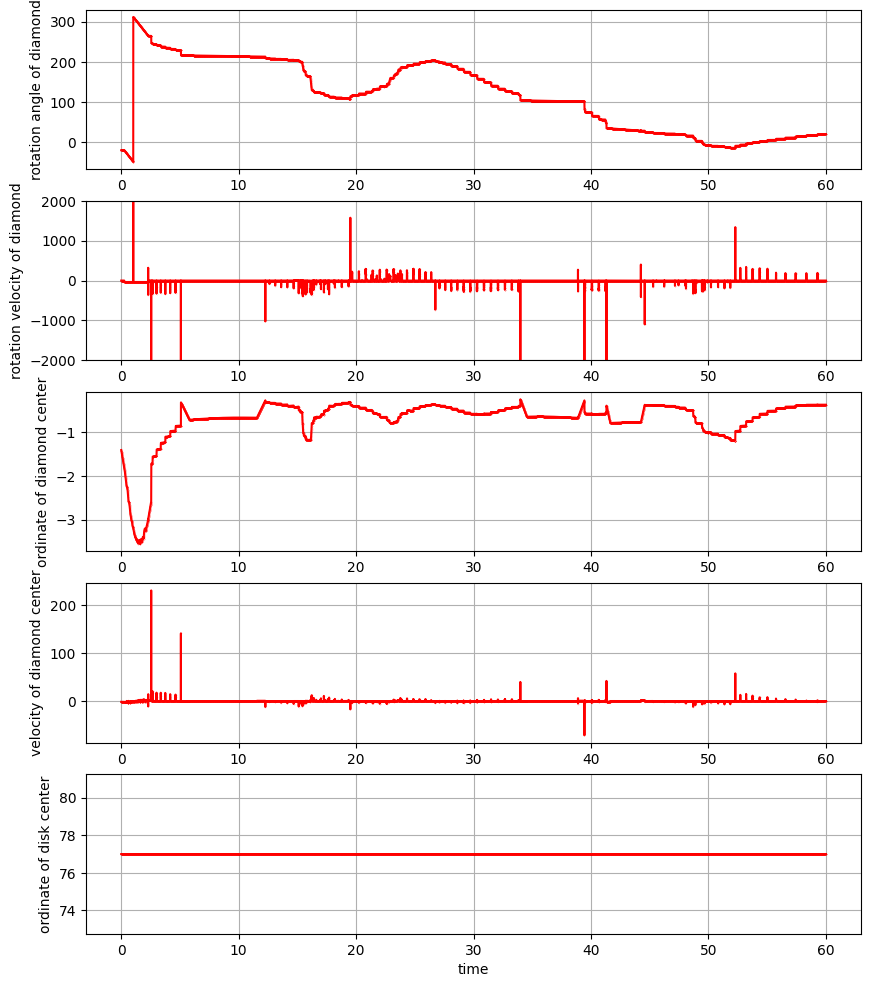

In [600]:
drangles = [(y2-y0)/(x2-x0) for x2, x0, y2, y0 in zip(time[1:], time, rangles[1:], rangles)]
dxvals = [(y2-y0)/(x2-x0) for x2, x0, y2, y0 in zip(time[1:], time, xvals[1:], xvals)]

fig, axs = plt.subplots(5, 1)
fig.set_size_inches(10.0, 12.0)

axs[0].plot(time, rangles, marker='.', color="red", markersize=0.1)
axs[0].set_ylabel('rotation angle of diamond')
axs[0].grid(True)

axs[1].plot(time[:-1], drangles, marker='.', color="red", markersize=0.1)
axs[1].set_ylabel('rotation velocity of diamond')
ylength = 2000
axs[1].set_ylim([-ylength, ylength])
axs[1].grid(True)

axs[2].plot(time, xvals, marker='.', linestyle="-", color="red", markersize=0.1)
axs[2].set_ylabel('ordinate of diamond center')
axs[2].grid(True)

axs[3].plot(time[:-1], dxvals, marker='.', linestyle="-", color="red", markersize=0.1)
axs[3].set_ylabel('velocity of diamond center')
axs[3].grid(True)

axs[4].plot(time, dvals, marker='.', linestyle="-", color="red", markersize=0.1)
axs[4].set_xlabel('time')
axs[4].set_ylabel('ordinate of disk center')
axs[4].grid(True)